In [22]:
import pandas as pd
import os
import scipy
import numpy as np
from glob import glob
from bct import degree

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [23]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

## Comparing number of edges retained, and strength of those edges, across different variance % thresholds

In [24]:
connectome_data_path = "/Users/abry4213/data/OCDA/HCP_Connectome"

region_lookup_table = (pd.read_csv(f"{connectome_data_path}/full_HCPMMP1_fsl20_both_hemis_lookup.csv")
                       .assign(Hemi__Region = lambda x: x.Hemisphere + "__" + x.Region_Name)
)

full_brain_no_thresh_connectome = pd.read_table(f"{connectome_data_path}/Full_brain_adj_mat_no_thresholding.txt", 
                                        sep=",", header=None)

full_brain_no_thresh_CV = pd.read_table(f"{connectome_data_path}/Full_brain_edge_CV_no_thresholding.txt", 
                                        sep=",", header=None)

In [25]:
full_brain_no_thresh_connectome_long = (full_brain_no_thresh_connectome
                                        .assign(Region_1_Index = lambda x: x.index)
                                        .melt(id_vars=["Region_1_Index"], 
                                              var_name="Region_2_Index", 
                                              value_name="Mean_SC_Strength")
                                        .query("Region_1_Index != Region_2_Index")

)

full_brain_no_thresh_CV_long = (full_brain_no_thresh_CV
                                        .assign(Region_1_Index = lambda x: x.index)
                                        .melt(id_vars=["Region_1_Index"], 
                                              var_name="Region_2_Index", 
                                              value_name="Edge_CV")
                                        .query("Region_1_Index != Region_2_Index")
)


full_brain_SC_stats = (full_brain_no_thresh_connectome_long
                        .merge(full_brain_no_thresh_CV_long, on=["Region_1_Index", "Region_2_Index"], how="inner")
                        )


# Map each Region_1_Index to the Region_Index column in region_lookup_table and save the corresponding Hemi__Region
full_brain_SC_stats = (full_brain_SC_stats
                       .assign(Region_1_Index = lambda x: x.Region_1_Index + 1,
                               Region_2_Index = lambda x: x.Region_2_Index + 1)
                        .merge(region_lookup_table, left_on="Region_1_Index", right_on="Region_Index", how="left")
                        .rename(columns={"Hemi__Region": "Region_1",
                                         "Region_Type": "Region_1_Type"})
                        .drop(columns=["Region_Index", "Region_1_Index", "Region_Name", "Hemisphere"])
                        .merge(region_lookup_table, left_on="Region_2_Index", right_on="Region_Index", how="left")
                        .rename(columns={"Hemi__Region": "Region_2",
                                         "Region_Type": "Region_2_Type"})
                        .drop(columns=["Region_Index", "Region_2_Index", "Region_Name", "Hemisphere"])

                        # Split Region_1 into one column for Hemisphere and one for Region
                        .assign(Region_1_Hemisphere = lambda x: x.Region_1.str.split("__").str[0],
                                Region_1 = lambda x: x.Region_1.str.split("__").str[1],
                                Region_2_Hemisphere = lambda x: x.Region_2.str.split("__").str[0],
                                Region_2 = lambda x: x.Region_2.str.split("__").str[1])

                        # Assign the connection type
                        .assign(Connection_Type = lambda x: np.where(x.Region_1_Hemisphere == x.Region_2_Hemisphere, "Intra-Hemispheric",
                                              np.where(x.Region_1 == x.Region_2, "Homotopic", "Inter-Hemispheric"))
                                              )
)

full_brain_SC_stats.head()

,Mean_SC_Strength,Edge_CV,Region_1_Type,Region_1,Region_2_Type,Region_2,Region_1_Hemisphere,Region_2_Hemisphere,Connection_Type
0,3.133544,8.240607,Cortex,MST,Cortex,V1,L,L,Intra-Hemispheric
1,8.554793,0.700533,Cortex,V6,Cortex,V1,L,L,Intra-Hemispheric
2,11.539763,0.269549,Cortex,V2,Cortex,V1,L,L,Intra-Hemispheric
3,10.958436,0.325453,Cortex,V3,Cortex,V1,L,L,Intra-Hemispheric
4,9.465654,0.516447,Cortex,V4,Cortex,V1,L,L,Intra-Hemispheric


In [26]:
CV_percentile_thresholds = [5, 15, 30, 45, 60, 75, 100]
CV_threshold_counts_list = []

for threshold in CV_percentile_thresholds:
    CV_threshold_counts = (full_brain_SC_stats
                           .assign(Edge_CV_Quantile = lambda x: pd.qcut(x.Edge_CV, 100, labels=False))
                           .query(f"Edge_CV_Quantile <= {threshold}")
                           .groupby(['Connection_Type']).size()
                           .reset_index(name='Count')
                           .assign(CV_Threshold = threshold)
                           )
    CV_threshold_counts_list.append(CV_threshold_counts)

CV_threshold_counts_df = pd.concat(CV_threshold_counts_list)
CV_threshold_counts_df

,Connection_Type,Count,CV_Threshold
0,Homotopic,102,5
1,Inter-Hemispheric,2492,5
2,Intra-Hemispheric,6034,5
0,Homotopic,134,15
1,Inter-Hemispheric,7972,15
2,Intra-Hemispheric,14898,15
0,Homotopic,174,30
1,Inter-Hemispheric,17318,30
2,Intra-Hemispheric,27078,30
0,Homotopic,216,45


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


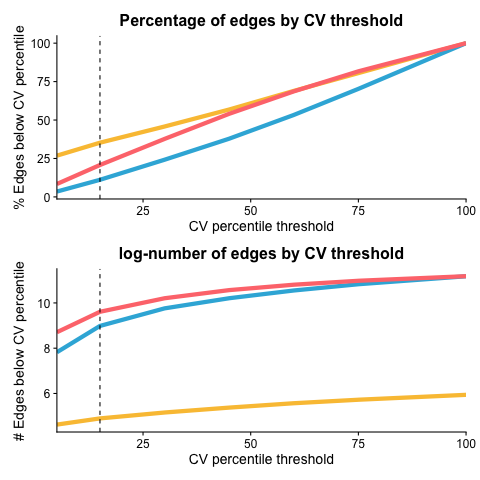

In [27]:
%%R -i CV_threshold_counts_df

# % edges
percent_edges_plot <- CV_threshold_counts_df %>%
    group_by(Connection_Type) %>% 
    mutate(percent_connections = 100*Count / max(Count)) %>%
    ggplot(data=., mapping=aes(x=CV_Threshold, y=percent_connections, color=Connection_Type)) +
    geom_line(linewidth=2) +
    scale_color_manual(values=c("Inter-Hemispheric" = "#36b3dc",
                                 "Intra-Hemispheric" = "#fe797c",
                                 "Homotopic" = "#fac241")) +
    ylab("% Edges below CV percentile") +
    xlab("CV percentile threshold") +
    ggtitle("Percentage of edges by CV threshold") +
    geom_vline(xintercept=15, linetype="dashed", color="black") +
    scale_x_continuous(expand=c(0,0)) +
    theme(legend.position='none', plot.title = element_text(hjust=0.5)) 

# # edges
num_edges_plot <- CV_threshold_counts_df %>%
    ggplot(data=., mapping=aes(x=CV_Threshold, y=log(Count), color=Connection_Type)) +
    geom_line(linewidth=2) +
    scale_color_manual(values=c("Inter-Hemispheric" = "#36b3dc",
                                 "Intra-Hemispheric" = "#fe797c",
                                 "Homotopic" = "#fac241")) +
    ylab("# Edges below CV percentile") +
    xlab("CV percentile threshold") +
    ggtitle("log-number of edges by CV threshold") +
    geom_vline(xintercept=15, linetype="dashed", color="black") +
    scale_x_continuous(expand=c(0,0)) +
    theme(legend.position='none', plot.title = element_text(hjust=0.5))

wrap_plots(list(percent_edges_plot, num_edges_plot), ncol=1)
# ggsave("../plots/R2R/SC_edgecount_by_CV_threshold.svg", width=3, height=6, dpi=300, units='in')

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 36 rows containing non-finite outside the scale range
(`stat_ydensity()`). 

R[write to console]: 2: Removed 36 rows containing non-finite outside the scale range
(`stat_summary()`). 

R[write to console]: 3: No shared levels found between `names(values)` of the manual scale and the
data's colour values. 

R[write to console]: 4: Removed 36 rows containing non-finite outside the scale range
(`stat_ydensity()`). 

R[write to console]: 5: Removed 36 rows containing non-finite outside the scale range
(`stat_summary()`). 

R[write to console]: 6: No shared levels found between `names(values)` of the manual scale and the
data's colour values. 



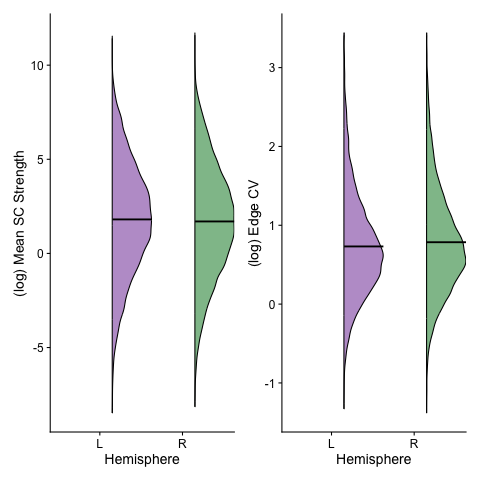

In [28]:
%%R -i full_brain_SC_stats

L_vs_R_strength <- full_brain_SC_stats %>%
    filter(Connection_Type == "Intra-Hemispheric") %>% 
    ggplot(mapping=aes(x=Region_1_Hemisphere, y=Mean_SC_Strength)) +
    geom_violinhalf(scale="width", color="black", aes(fill=Region_1_Hemisphere),
               position = position_nudge(x=0.15), width=0.95, alpha=0.85)  +
#     geom_point(position = position_jitter(width = 0.05, height=0), aes(color=Region_1_Hemisphere),
#                             size = 1.7, alpha=0.3, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.475, linewidth=0.35, 
            show.legend=FALSE, position = position_nudge(x=0.39)) +
    scale_color_manual(values=c("L" = "#b18cc7", "R" = "#7ab485")) +
    scale_fill_manual(values=c("L" = "#b18cc7", "R" = "#7ab485")) +
    ylab("(log) Mean SC Strength") +
    xlab("Hemisphere") +
    theme(legend.position='none')

L_vs_R_CV <- full_brain_SC_stats %>%
    filter(Connection_Type == "Intra-Hemispheric") %>% 
    ggplot(mapping=aes(x=Region_1_Hemisphere, y=log(Edge_CV))) +
    geom_violinhalf(scale="width", color="black", aes(fill=Region_1_Hemisphere),
               position = position_nudge(x=0.15), width=0.95, alpha=0.85)  +
#     geom_point(position = position_jitter(width = 0.05, height=0), aes(color=Region_1_Hemisphere),
#                             size = 1.7, alpha=0.3, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.475, linewidth=0.35, 
            show.legend=FALSE, position = position_nudge(x=0.39)) +
    scale_color_manual(values=c("L" = "#b18cc7", "R" = "#7ab485")) +
    scale_fill_manual(values=c("L" = "#b18cc7", "R" = "#7ab485")) +
    ylab("(log) Edge CV") +
    xlab("Hemisphere") +
    theme(legend.position='none')

wrap_plots(list(L_vs_R_strength, L_vs_R_CV), nrow=1) 
# ggsave("../plots/R2R/Left_vs_Right_IntraHemi_SC_properties.svg", width=6, height=3, dpi=300, units='in')

In [31]:
RH_cortex_015_CV = pd.read_table(f"{connectome_data_path}/RH_cortex_0.15_CV_density.txt", sep=',', header=None)
RH_cortex_015_CV_degrees = pd.DataFrame({"Degree": degree.degrees_und(RH_cortex_015_CV.values),
                                         "Strength": degree.strengths_und(RH_cortex_015_CV.values),
                                         "Hemisphere": "Right",
                                         "Node_Index": np.arange(1, RH_cortex_015_CV.shape[0] + 1),
                                        "CV_Percentile_Thres": 0.15})

LH_cortex_015_CV = pd.read_table(f"{connectome_data_path}/LH_cortex_0.15_CV_density.txt", sep=',', header=None)
LH_cortex_015_CV_degrees = pd.DataFrame({"Degree": degree.degrees_und(LH_cortex_015_CV.values),
                                         "Strength": degree.strengths_und(LH_cortex_015_CV.values),
                                        "Hemisphere": "Left",
                                        "Node_Index": np.arange(1, LH_cortex_015_CV.shape[0] + 1),
                                        "CV_Percentile_Thres": 0.15})

all_cortex_015_CV_degrees = pd.concat([RH_cortex_015_CV_degrees, LH_cortex_015_CV_degrees], axis=0)
all_cortex_015_CV_degrees.head()

,Degree,Strength,Hemisphere,Node_Index,CV_Percentile_Thres
0,52.0,320.788733,Right,1,0.15
1,7.0,45.958381,Right,2,0.15
2,44.0,227.653188,Right,3,0.15
3,57.0,323.827389,Right,4,0.15
4,62.0,364.065378,Right,5,0.15


In [45]:
%%R -i all_cortex_015_CV_degrees 

degree_plot <- all_cortex_015_CV_degrees %>% 
    select(Node_Index, Degree, Hemisphere) %>% 
    pivot_wider(names_from=Hemisphere, values_from=Degree) %>%
    ggplot(data=., mapping=aes(x=Left, y=Right)) +
    geom_smooth(method="lm", color="black", se=FALSE, linewidth=0.5) +
    ggpubr::stat_cor(method="pearson", label.x=0.5, label.y=0.5, size=3) +
    ggtitle("Node degree") +
    geom_point(alpha=0.6, color="blue") +
    theme(plot.title = element_text(hjust=0.5))

strength_plot <- all_cortex_015_CV_degrees %>% 
    select(Node_Index, Strength, Hemisphere) %>% 
    pivot_wider(names_from=Hemisphere, values_from=Strength) %>%
    ggplot(data=., mapping=aes(x=Left, y=Right)) +
    geom_smooth(method="lm", color="black", se=FALSE, linewidth=0.5) +
    ggpubr::stat_cor(method="pearson", label.x=0.5, label.y=0.5, size=3) +
    ggtitle("Node strength") +
    geom_point(alpha=0.6, color="orange") +
    theme(plot.title = element_text(hjust=0.5))

wrap_plots(list(degree_plot, strength_plot), nrow=2)
ggsave("../plots/R2R/Left_vs_Right_node_degree_strength.svg", width=3, height=6, dpi=300, units='in')

`geom_smooth()` using formula = 'y ~ x'


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


`geom_smooth()` using formula = 'y ~ x'


# How does degree distribution shape vary with the threshold applied?

In [18]:
RH_cortex_015_CV = pd.read_table(f"{connectome_data_path}/RH_cortex_0.15_CV_density.txt", sep=',', header=None)
RH_cortex_015_CV_degrees = pd.DataFrame({"Degree": degree.degrees_und(RH_cortex_015_CV.values),
                                         "Strength": degree.strengths_und(RH_cortex_015_CV.values),
                                        "CV_Percentile_Thres": 0.15})

RH_cortex_03_CV = pd.read_table(f"{connectome_data_path}/RH_cortex_0.30_CV_density.txt", sep=',', header=None)
RH_cortex_03_CV_degrees = pd.DataFrame({"Degree": degree.degrees_und(RH_cortex_03_CV.values),
                                        "Strength": degree.strengths_und(RH_cortex_03_CV.values),
                                        "CV_Percentile_Thres": 0.3})

RH_cortex_045_CV = pd.read_table(f"{connectome_data_path}/RH_cortex_0.45_CV_density.txt", sep=',', header=None)
RH_cortex_045_CV_degrees = pd.DataFrame({"Degree": degree.degrees_und(RH_cortex_045_CV.values),
                                        "Strength": degree.strengths_und(RH_cortex_045_CV.values),
                                        "CV_Percentile_Thres": 0.45})

RH_cortex_06_CV = pd.read_table(f"{connectome_data_path}/RH_cortex_0.60_CV_density.txt", sep=',', header=None)
RH_cortex_06_CV_degrees = pd.DataFrame({"Degree": degree.degrees_und(RH_cortex_06_CV.values),
                                        "Strength": degree.strengths_und(RH_cortex_06_CV.values),
                                        "CV_Percentile_Thres": 0.6})

RH_cortex_1_CV = pd.read_table(f"{connectome_data_path}/RH_cortex_adj_mat_no_thresholding.txt", sep=',', header=None)
RH_cortex_1_CV_degrees = pd.DataFrame({"Degree": degree.degrees_und(RH_cortex_1_CV.values),
                                        "Strength": degree.strengths_und(RH_cortex_1_CV.values),
                                        "CV_Percentile_Thres": 1.0})

# Combine all the dataframes into one
degree_by_threshold_df = pd.concat([RH_cortex_015_CV_degrees, 
                                    RH_cortex_03_CV_degrees,
                                    RH_cortex_045_CV_degrees,
                                    RH_cortex_06_CV_degrees,
                                    RH_cortex_1_CV_degrees])

In [19]:
degree_by_threshold_df.head()

,Degree,Strength,CV_Percentile_Thres
0,52.0,320.788733,0.15
1,7.0,45.958381,0.15
2,44.0,227.653188,0.15
3,57.0,323.827389,0.15
4,62.0,364.065378,0.15


In [17]:
%%R -i degree_by_threshold_df

degree_by_threshold_df %>% 
    mutate(CV_Percentile_Thres = as.factor(CV_Percentile_Thres)) %>%
    ggplot(data=., mapping=aes(x=Degree, fill=CV_Percentile_Thres)) +
    geom_density(aes(y=..scaled..), alpha=0.5, position="identity") +
    ylab("Scaled density (a.u.)") +
    xlab("Degree (k)") +
    labs(fill="Edge CV percentile threshold") +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    scale_fill_viridis_d(option='plasma') +
    theme(legend.position='bottom')
# ggsave("../plots/connectome_analysis/Degree_distribution_by_CV_threshold.svg", width=4.5, height=3, dpi=300, units='in')

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [21]:
%%R -i degree_by_threshold_df

degree_by_threshold_df %>% 
    mutate(CV_Percentile_Thres = as.factor(CV_Percentile_Thres)) %>%
    ggplot(data=., mapping=aes(x=Strength, fill=CV_Percentile_Thres)) +
    geom_density(aes(y=..scaled..), alpha=0.5, position="identity") +
    ylab("Scaled density (a.u.)") +
    xlab("Strength (s)") +
    labs(fill="Edge CV percentile threshold") +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    scale_fill_viridis_d(option='plasma') +
    theme(legend.position='bottom')
# ggsave("../plots/connectome_analysis/Strength_distribution_by_CV_threshold.svg", width=4.5, height=3, dpi=300, units='in')

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In addition: Warning message:
Removed 180 rows containing non-finite outside the scale range
(`stat_density()`). 
